https://docs.nexosis.com/clients/python

In [1]:
import datetime as datetime
import json
import nexosisapi
from nexosisapi.column_metadata import ColumnMetadata
from nexosisapi.time_interval import TimeInterval
import dateutil.parser as date_parser
import pandas as pd
import seaborn as sns
import iso8601
%matplotlib inline

def load_api_secrets(filename):
    """Convenience to load the API key from a json file."""
    try:
        with open(filename, 'r') as fp:
            api_params = json.load(fp)
    except Exception as e:
        print('Failed to load API secrets key: {}'.format(e))
        api_params = None
    return api_params['key']

I will load my API key from a local JSON file to keep my credentials secure.

In [2]:
API_key_filepath = '/Users/robincole/Desktop/Nexosis_API_key.json'
API_key = load_api_secrets(API_key_filepath)

Lets download the .csv data locally

In [3]:
data_url = "https://raw.githubusercontent.com/Nexosis/sampledata/master/LocationA.csv"

Lets have a look at the data using Pandas

In [4]:
df = pd.read_csv(data_url, index_col=0)
df.head()

,sales,transactions
timeStamp,,
2012-12-31 00:00:00,2922.13,459
2013-01-01 00:00:00,1500.56,195
2013-01-02 00:00:00,4078.52,696
2013-01-03 00:00:00,4545.69,743
2013-01-04 00:00:00,4872.63,797


In [5]:
df.index[0] # Our index data is a string timestamp, and not in ISO-8601 format

'2012-12-31 00:00:00'

Lets convert the index to a datetime object

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
df.head()

,sales,transactions
timeStamp,,
2012-12-31,2922.13,459
2013-01-01,1500.56,195
2013-01-02,4078.52,696
2013-01-03,4545.69,743
2013-01-04,4872.63,797


In [8]:
"The data has {} entries".format(df.shape[0])

'The data has 1477 entries'

In [9]:
df['sales'][0] # Sales are floats

2922.13

In [10]:
df['transactions'][0] # transactions are int

459

OK so we have on each day, a record of the value of sales (guess dollars) and the number of transactions

In [11]:
"We have {} years of data".format(round((df.index[-1] - df.index[0]).days/365, 0))

'We have 4.0 years of data'

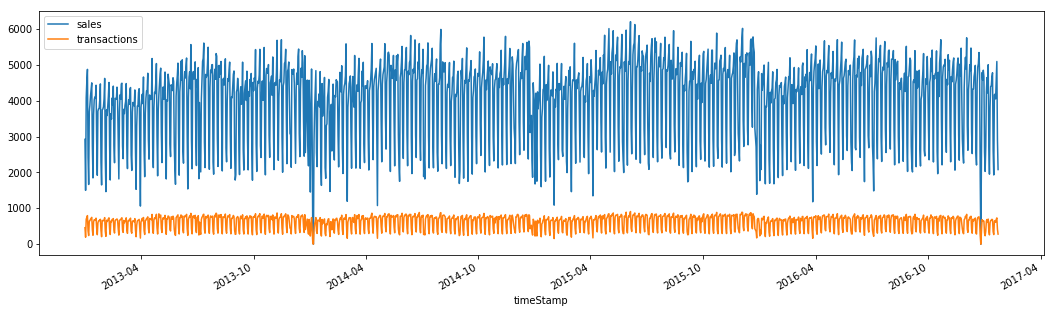

In [12]:
df.plot(figsize=(18,5));

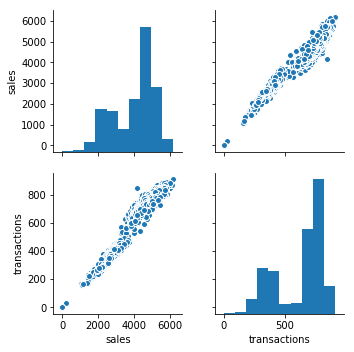

In [13]:
sns.pairplot(df);

OK so we have a bimodal distribution, likely weekday and weekend sales.

## Nexosis
We will upload our data to nexosis and create a new model. It requires that timestamps are in [ISO-8601 format](https://docs.nexosis.com/guides/working-with-dates) - use `date.isoformat()`. Note that when uploading data to nexosis, the contents of the columns are automatically inferred.

In [14]:
dataset_name = 'widget-sales'

In [15]:
%%time
client = nexosisapi.Client(API_key)

CPU times: user 35 µs, sys: 1 µs, total: 36 µs
Wall time: 39.8 µs


In [16]:
client.get_account_balance() 

0.0

Lets download and save the data csv

In [17]:
filename = 'LocationA.csv'
pd.read_csv(data_url).to_csv(filename)

Lets check what models are on the server

In [18]:
for dataset in client.datasets.list():
    print(dataset.name)

widget-sales
classification-kddcup
classification-csgo
regression-housing
anomalies-lympho
impact-store
forecast-store
classification-iris


OK we already have a `widget-sales` dataset so lets delete that and start fresh

In [19]:
client.datasets.remove(dataset_name) 

Check that was successful

In [20]:
for dataset in client.datasets.list():
    print(dataset.name)

classification-kddcup
classification-csgo
regression-housing
anomalies-lympho
impact-store
forecast-store
classification-iris


OK great it's gone, lets upload our data

### Data upload

In [21]:
with open(filename) as f:
    result = client.datasets.create_csv(dataset_name, f)

`result` is a `datasetsummary` object https://github.com/Nexosis/nexosisclient-py/blob/master/nexosisapi/dataset_summary.py

In [22]:
result

Dataset({
    'dataSetName': widget-sales
    'columns': {'': ColumnMetadata({'dataType': 'numericMeasure', 'role': 'feature', 'aggregation': 'mean', 'imputation': 'mean'}), 'timeStamp': ColumnMetadata({'dataType': 'date', 'role': 'timestamp'}), 'sales': ColumnMetadata({'dataType': 'numericMeasure', 'role': 'feature', 'aggregation': 'mean', 'imputation': 'mean'}), 'transactions': ColumnMetadata({'dataType': 'numericMeasure', 'role': 'feature', 'aggregation': 'mean', 'imputation': 'mean'})},
})

OK lets get back the dataset just to check whats been uploaded

In [23]:
my_dataset = client.datasets.get(dataset_name)

In [24]:
my_dataset.metadata.keys()

dict_keys(['', 'sales', 'timeStamp', 'transactions'])

In [25]:
my_dataset.item_total

1477

In [26]:
my_dataset.total_pages

30

In [27]:
my_dataset.total_pages*my_dataset.page_size

1500

In [28]:
"OK so my data is spread over {} pages".format(my_dataset.page_size)

'OK so my data is spread over 50 pages'

In [29]:
my_dataset.data[0]

{'': '0',
 'sales': '2922.13',
 'timeStamp': '2012-12-31 00:00:00',
 'transactions': '459'}

OK data upload looks good.

### Forecasting
Lets make a forecast.

In [34]:
%%time

start_date = datetime.date(2017, 1, 22)
end_date = datetime.date(2017, 2, 22)

session = client.sessions.create_forecast(dataset_name, 'transactions', start_date, end_date)

CPU times: user 19.6 ms, sys: 2.93 ms, total: 22.5 ms
Wall time: 1.04 s


In [39]:
session.status_history

[{'date': '2018-04-11T04:30:00.363436+00:00', 'status': 'requested'}]

Initially `session.status` is `requested`

In [40]:
# after some time passes you can get results...
results = client.sessions.get_results(session.session_id)

In [41]:
results.data

[]

OK no results to display.. 